In [1]:
import numpy as np
import itertools
import time
import random
import pandas as pd
import importlib
import multiprocessing
import chromosome_simulation_code_soft_limit
import pickle
import gc

In [2]:
from collections import Counter

In [3]:
from numba import jit
from numba.typed import List

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(list(np.linspace(0,1,numChrs))))
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 13}
fontLabel = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

In [7]:
importlib.reload(chromosome_simulation_code_soft_limit)
from chromosome_simulation_code_soft_limit import *

# Importing Data

In [8]:
inFile = "/home/derek/Dropbox/projects/markov_chromosomes/DToL_data/lep_chromosomes_lengths_20210604_by_taxon.DToL_autosomes.tsv";
df = pd.read_csv(inFile,sep='\t',header = 0, names = ['species','sample_id','length']);

def format_lep_df(thisDF):
    new_df = pd.DataFrame()
    new_df["Species"] = thisDF["species"]
    k = len(new_df)
    new_df["chromosome number"]=k
    new_df["chromosome index"] = list(range(1,k+1))
    
    lengths = thisDF["length"]
    lengths = np.sort(lengths)
    lengths = lengths/sum(lengths)
    new_df["relative size"] = lengths
#     new_df["index"] = [i/(k+1) for i in range(1,k+1)]

#     mean = np.mean(new_df["relative size"])
#     new_df["mean_norm"] = new_df["relative size"]/mean
    
    return(new_df)

formatted = [format_lep_df(y) for x,y in df.groupby('species')]

dfLep = pd.concat(formatted)





inFile2 = "/home/derek/Dropbox/projects/markov_chromosomes/chromsome_length_tables/msr011_Supplementary_Data/supplement_tableS2_0320_1.csv"
df1 = pd.read_csv(inFile2,sep=',',header = 0);

def simplify_this_df(thisDF):
    new_df = pd.DataFrame()
    new_df["Species"] = thisDF["Species"]
    new_df["chromosome number"] = thisDF["Chromosome number"]
    new_df["chromosome index"] = thisDF["Chromosome\nindex"]
    tot = sum(thisDF["Chromosome\nsize"])
    new_df["relative size"] = thisDF["Chromosome\nsize"]/tot
    k = len(new_df)
#     new_df["index"] = [i/(k+1) for i in range(1,k+1)]
#     mean = np.mean(new_df["relative size"])
#     new_df["mean_norm"] = new_df["relative size"]/mean
    return(new_df)

df2 = df1[df1["Common name"] != "Prokaryotes"]
simplified = [simplify_this_df(y) for x, y in df2.groupby('Species')]
dfEuk = pd.concat(simplified)



inFile = "/home/derek/Dropbox/projects/markov_chromosomes/heliconius_data/heliconius_data.csv"
df3 = pd.read_csv(inFile,sep=',',header = 0)
speciesNames = df3.columns.values.tolist()
sizeDistList = []
for name in speciesNames:
    sizes = list(df3[name])
    sizes = np.array(sizes)
    total = sum(sizes)
    relSizes = sizes/total
    relSizes = np.sort(relSizes)
    k = len(relSizes)
    for idx, val in enumerate(relSizes):
        chrId = idx+1
        sizeDistList.append([name,k,chrId,val])
sizeDistList

dfHel = pd.DataFrame(sizeDistList, columns = ["Species","chromosome number","chromosome index","relative size"])
dfHel


dfCombined = pd.concat([dfEuk,dfLep,dfHel])
dfCombined

,Species,chromosome number,chromosome index,relative size
106,Anopheles gambiae,2.0,1.0,0.461797
107,Anopheles gambiae,2.0,2.0,0.538203
447,Apis mellifera,16.0,1.0,0.030101
448,Apis mellifera,16.0,2.0,0.041996
449,Apis mellifera,16.0,3.0,0.044467
...,...,...,...,...
315,H. sara,20.0,16.0,0.062821
316,H. sara,20.0,17.0,0.064257
317,H. sara,20.0,18.0,0.067124
318,H. sara,20.0,19.0,0.067605


# Calculation model score and goodness of fits

In [10]:
model_names = ['EB/EF','EB/EF Lim','PB/EF','PB/EF Lim','EB/PF','EB/PF Lim','PB/PF','PB/PF Lim','EB/SFBS','EB/SFBS Lim','PB/SFBS','PB/SFBS Lim']
model_ids = ['m0','m0_soft_lim', 'm1','m1_soft_lim', 'm2', 'm2_soft_lim', 'm3', 'm3_soft_lim', 'm4', 'm4_soft_lim', 'm5', 'm5_soft_lim']
model_ids_short = ['m0','m0_lim', 'm1','m1_lim', 'm2', 'm2_lim', 'm3', 'm3_lim', 'm4', 'm4_lim', 'm5', 'm5_lim']

In [90]:
# speciesList = [x for x in dfCombined["Species"].unique()]
# dfResults = pd.DataFrame(index = speciesList)
# for model in model_ids_short:
#     dfResults[model] = [[-1,-1] for x in speciesList]
# dfResults

,m0,m0_lim,m1,m1_lim,m2,m2_lim,m3,m3_lim,m4,m4_lim,m5,m5_lim
Anopheles gambiae,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
Apis mellifera,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
Arabidopsis lyrata,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
Arabidopsis thaliana,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
Ashbya gossypii,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
...,...,...,...,...,...,...,...,...,...,...,...,...
H. himera,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
H. hecalesia,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
H. telesiphe,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"
H. demeter,"[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]","[-1, -1]"


In [91]:
numSamples = 1000 # for bootstrapping

In [92]:
kUnique = [int(x) for x in dfCombined["chromosome number"].unique() if x <=49]
print(kUnique)


[2, 16, 8, 5, 7, 3, 29, 13, 38, 17, 14, 20, 25, 6, 11, 31, 30, 21, 22, 35, 19, 12, 24, 23, 33, 4, 10, 18, 28, 27, 47, 44]


In [93]:


# for idx,model in enumerate(model_ids):
#     baseFile = "./simulation_data/" + model + "_chrsByBeta.npy"
#     chrsByBeta = np.load(baseFile)
#     flat_chrsByBeta = np.array(flatten(chrsByBeta))
    
#     del(chrsByBeta)
#     gc.collect()
    
#     modelShortName = model_ids_short[idx]
    
#     print("data loaded and flattened: "+model+" : "+modelShortName)
    
#     for k in kUnique:
        
#         x1_ = get_size_distribution_given_n_chrs(flat_chrsByBeta,k)
#         means_ = [np.mean(_) for _ in x1_]
        
#         x1T_ = x1_.transpose()
#         tot = len(x1T_)
#         skip = int(tot/numSamples)
#         if skip < 1:
#             skip = 1
#         samples_ = x1T_[0:-1:skip]
        
        
#         distanceList = [get_square_distance(y,means_) for y in samples_]
        
#         speciesWithK = dfCombined[dfCombined["chromosome number"]==k]["Species"].unique()

#         for thisSpecies in speciesWithK:
#             observed = np.sort(dfCombined[dfCombined["Species"]==thisSpecies]["relative size"].to_numpy())
#             observedDistance = get_square_distance(observed,means_)
            
#             allDistances = distanceList + [observedDistance]
#             allDistances = list(np.sort(allDistances))
#             i = allDistances.index(observedDistance)
#             score = i/len(samples_)            
        
#             dfResults.at[thisSpecies,modelShortName] = [observedDistance,score,len(samples_)]
#     del(flat_chrsByBeta)
#     gc.collect()


data loaded and flattened: m0 : m0
data loaded and flattened: m0_soft_lim : m0_lim
data loaded and flattened: m1 : m1
data loaded and flattened: m1_soft_lim : m1_lim
data loaded and flattened: m2 : m2
data loaded and flattened: m2_soft_lim : m2_lim
data loaded and flattened: m3 : m3
data loaded and flattened: m3_soft_lim : m3_lim
data loaded and flattened: m4 : m4
data loaded and flattened: m4_soft_lim : m4_lim
data loaded and flattened: m5 : m5
data loaded and flattened: m5_soft_lim : m5_lim


In [95]:
# dfResults.to_pickle("markov_chr_model_fit.pkl")

Each entry in the results data frame is a list.  The list is the { distance from mean, goodness of fit, simulation subsample size }. Here, the mean from sims was calculated pooling all data across the khat values simulated, and the simulation subsample was taken from that aggregate data. 

In [11]:
dfResults = pd.read_pickle("markov_chr_model_fit.pkl")
dfResults

,m0,m0_lim,m1,m1_lim,m2,m2_lim,m3,m3_lim,m4,m4_lim,m5,m5_lim
Anopheles gambiae,"[0.12747898174283817, 0.948, 1000]","[0.05859196090070595, 0.788027477919529, 1019]","[0.08929486459462453, 0.841897233201581, 1012]","[0.04905310265186273, 0.7621890547263681, 1005]","[0.05101609779834739, 0.7700587084148728, 1022]","[0.029059616626282397, 0.6842105263157895, 1007]","[0.03855767987578802, 0.7295162882527148, 1013]","[0.025834331131605878, 0.6683266932270916, 1004]","[0.15230973754010263, 0.9622641509433962, 1007]","[0.10113068450925478, 0.9198813056379822, 1011]","[0.11165502077729125, 0.9333333333333333, 1005]","[0.07264333304856799, 0.8339960238568589, 1006]"
Apis mellifera,"[0.10837781553943425, 0.952191235059761, 1004]","[0.013900319019877492, 0.9564787339268052, 1011]","[0.018615752281466495, 0.9613478691774033, 1009]","[0.006402511441546185, 0.933597621407334, 1009]","[0.007042772228894089, 0.9314796425024826, 1007]","[0.0033613896112896996, 0.8778550148957299, 1007]","[0.0038031277763895884, 0.9213147410358565, 1004]","[0.002266373634322929, 0.8665338645418327, 1004]","[0.15256165820293122, 0.999000999000999, 1001]","[0.06207684963411295, 0.8792079207920792, 1010]","[0.03810556954768675, 0.8416334661354582, 1004]","[0.015161985216114008, 0.736318407960199, 1005]"
Arabidopsis lyrata,"[0.18832871976217047, 0.9640718562874252, 1002]","[0.042697150409557336, 0.9435643564356435, 1010]","[0.05531611780295448, 0.9671641791044776, 1005]","[0.025841652227094607, 0.9624134520276953, 1011]","[0.02959457660116044, 0.9670658682634731, 1002]","[0.016579773060108945, 0.9570858283433133, 1002]","[0.018503195983611186, 0.9661691542288557, 1005]","[0.011987741379666983, 0.9613095238095238, 1008]","[0.2090687404280168, 1.0, 1007]","[0.1238979833353826, 0.952047952047952, 1001]","[0.10499203067865595, 0.9165009940357853, 1006]","[0.05728426269600349, 0.8545816733067729, 1004]"
Arabidopsis thaliana,"[0.18032378616324996, 0.960435212660732, 1011]","[0.04501957919415137, 0.9158415841584159, 1010]","[0.06206102987846526, 0.9326065411298315, 1009]","[0.027311866347011743, 0.906093906093906, 1001]","[0.034476681373752115, 0.9015904572564613, 1006]","[0.017355670832531984, 0.8602794411177644, 1002]","[0.020606757127155567, 0.8801980198019802, 1010]","[0.012165623259267254, 0.7624750499001997, 1002]","[0.18314304019692398, 0.9990029910269193, 1003]","[0.12169001477736961, 0.9285004965243296, 1007]","[0.11614856312917704, 0.9364448857994042, 1007]","[0.06968984589751878, 0.8238805970149253, 1005]"
Ashbya gossypii,"[0.16615380046597641, 0.9632936507936508, 1008]","[0.02942653032586195, 0.8976143141153081, 1006]","[0.04073614887962261, 0.9302788844621513, 1004]","[0.015124543031528076, 0.8790882061446977, 1009]","[0.018409955112619537, 0.8934262948207171, 1004]","[0.008193184839730383, 0.7623762376237624, 1010]","[0.009277066302910043, 0.7892644135188867, 1006]","[0.005026457293096799, 0.6267326732673267, 1010]","[0.18172937000536138, 0.9980119284294234, 1006]","[0.10990865672566369, 0.9174129353233831, 1005]","[0.09444169864184064, 0.908183632734531, 1002]","[0.049316016562085965, 0.8341608738828202, 1007]"
...,...,...,...,...,...,...,...,...,...,...,...,...
H. himera,"[0.12744599601880302, 0.9771598808341608, 1007]","[0.020176115756889365, 0.9841427155599604, 1009]","[0.024992110848483587, 0.9840954274353877, 1006]","[0.010060543333366225, 0.9840637450199203, 1004]","[0.010631757857391391, 0.9851190476190477, 1008]","[0.005602863349840322, 0.9871031746031746, 1008]","[0.006099317179441522, 0.9841112214498511, 1007]","[0.003675404214679277, 0.9871159563924677, 1009]","[0.1799468715620649, 1.0, 1002]","[0.07955276117277296, 0.9121756487025948, 1002]","[0.049427820351899784, 0.8941058941058941, 1001]","[0.023829592249918277, 0.8635458167330677, 1004]"
H. hecalesia,"[0.12710099083392468, 0.9761668321747765, 1007]","[0.019991336914202, 0.9841427155599604, 1009]","[0.024766772204665492, 0.9840954274353877, 1006]","[0.009944099547803655, 0.9840637450199203, 1

# exploring data results

In [12]:
speciesNames = dfCombined[dfCombined["chromosome number"]<50]["Species"].unique()

In [13]:
bestModels = []
for species in speciesNames:
    x_ = dfResults.loc[species]
    x_ = list(x_)
    scores = [xs[0] for xs in x_]
    fits = [xs[1] for xs in x_]
    minScore = min(scores)
    idxMin = scores.index(minScore)
    idxMin
    bestModels.append([species,model_ids_short[idxMin],scores[idxMin],fits[idxMin]])


In [14]:
test = pd.DataFrame(bestModels,columns=["species","model","score","fit"])
test

,species,model,score,fit
0,Anopheles gambiae,m3_lim,0.025834,0.668327
1,Apis mellifera,m3_lim,0.002266,0.866534
2,Arabidopsis lyrata,m3_lim,0.011988,0.961310
3,Arabidopsis thaliana,m3_lim,0.012166,0.762475
4,Ashbya gossypii,m3_lim,0.005026,0.626733
...,...,...,...,...
152,H. himera,m3_lim,0.003675,0.987116
153,H. hecalesia,m3_lim,0.003638,0.986125
154,H. telesiphe,m3_lim,0.003674,0.987116
155,H. demeter,m3_lim,0.003327,0.976214


At 97th percentil cut-off:

In [120]:
test[test['model']!='m3_lim']

,species,model,score,fit
22,Cyanothece sp. 2,m4,0.022356,0.477656
29,Gallus gallus 1,m0,0.007842,0.359281
37,Leishmania braziliensis,m2_lim,0.000373,0.509940
44,Mycosphaerella graminicola 3,m2,0.001111,0.436563
45,Ornithorhynchus anatinus 1,m1,0.004908,0.734390
51,Phaeodactylum tricornutum,m2_lim,0.000583,0.715842
63,Taeniopygia guttata 1,m1,0.003934,0.878968
64,Thalassiosira pseudonana,m2_lim,0.000845,0.464286


In [68]:
## exploring data with best fitting m3_lim model
test1 = test[test['model']=='m3_lim']
print(test1)
allList = []

eukFits = []
for species in dfEuk["Species"].unique():
    if list(test[(test['species']==species) & (test['model']=='m3_lim') ]['fit']) == []:
        continue
    eukFits.append(list(test1[(test1['species']==species)]["fit"])[0])
    allList.append(["eukaryotes",list(test1[(test1['species']==species)]["fit"])[0]])
    
lepFits = []
for species in dfLep[dfLep["chromosome number"]<=50]["Species"].unique():
    if list(test[(test['species']==species) & (test['model']=='m3_lim') ]['fit']) == []:
        continue
    lepFits.append(list(test1[test1['species']==species]["fit"])[0])
    allList.append(["lepidoptera",list(test1[test1['species']==species]["fit"])[0]])

helFits = []
for species in dfHel["Species"].unique():
    if list(test[(test['species']==species) & (test['model']=='m3_lim') ]['fit']) == []:
        continue
    helFits.append(list(test1[test1['species']==species]['fit'])[0])
    allList.append(["lepidoptera",list(test1[test1['species']==species]["fit"])[0]])

print(min(eukFits))
print(min(lepFits))
print(min(helFits))

alldf = pd.DataFrame(allList,columns=["dataset","fit"])


# plt.hist(eukFits)
# plt.show()
# plt.hist(lepFits)
# plt.show()
# plt.hist(helFits)
# plt.show()

                  species   model     score       fit
0       Anopheles gambiae  m3_lim  0.025834  0.668327
1          Apis mellifera  m3_lim  0.002266  0.866534
2      Arabidopsis lyrata  m3_lim  0.011988  0.961310
3    Arabidopsis thaliana  m3_lim  0.012166  0.762475
4         Ashbya gossypii  m3_lim  0.005026  0.626733
..                    ...     ...       ...       ...
152             H. himera  m3_lim  0.003675  0.987116
153          H. hecalesia  m3_lim  0.003638  0.986125
154          H. telesiphe  m3_lim  0.003674  0.987116
155            H. demeter  m3_lim  0.003327  0.976214
156               H. sara  m3_lim  0.003349  0.978196

[149 rows x 4 columns]
0.12388503468780972
0.878727634194831
0.9653121902874133


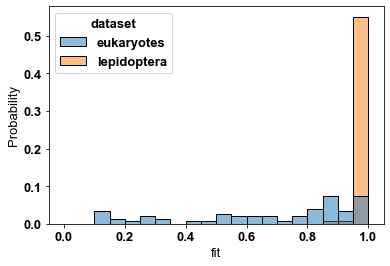

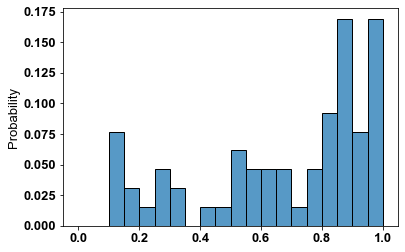

In [69]:
sns.histplot(data = alldf,x = 'fit',hue = 'dataset',common_bins=True,stat="probability",bins=20,binrange=[0,1.0])
plt.show()
sns.histplot(eukFits,common_bins=True,stat="probability",bins=20,binrange=[0,1.0])
plt.show()

In [68]:
noLimModels = ["m0","m1","m2","m3","m4","m5"]
dfNoLimResults = dfResults[noLimModels]


bestNoLimModels = []

for species in speciesNames:
    x_ = dfNoLimResults.loc[species]
    x_ = list(x_)
    scores = [xs[0] for xs in x_]
    fits = [xs[1] for xs in x_]
    minScore = min(scores)
    idxMin = scores.index(minScore)
    idxMin
    bestNoLimModels.append([species,noLimModels[idxMin],scores[idxMin],fits[idxMin]])


**species where m3_lim is not the best model (among all models)**

In [570]:
test = pd.DataFrame(bestModels,columns=["species","model","score","fit"])
test[(test["model"]!="m3_lim") & (test["fit"]<=0.97)]

,species,model,score,fit
22,Cyanothece sp. 2,m4,0.022356,0.477656
29,Gallus gallus 1,m0,0.007842,0.359281
37,Leishmania braziliensis,m2_lim,0.000373,0.509940
44,Mycosphaerella graminicola 3,m2,0.001111,0.436563
45,Ornithorhynchus anatinus 1,m1,0.004908,0.734390
51,Phaeodactylum tricornutum,m2_lim,0.000583,0.715842
63,Taeniopygia guttata 1,m1,0.003934,0.878968
64,Thalassiosira pseudonana,m2_lim,0.000845,0.464286


**species where m3 is not the best model among all non-limited models**

In [71]:
test = pd.DataFrame(bestNoLimModels,columns=["species","model","score","fit"])
test[test["model"]!="m3"]

,species,model,score,fit
22,Cyanothece sp. 2,m4,0.022356,0.477656
29,Gallus gallus 1,m0,0.007842,0.359281
44,Mycosphaerella graminicola 3,m2,0.001111,0.436563
45,Ornithorhynchus anatinus 1,m1,0.004908,0.734390
63,Taeniopygia guttata 1,m1,0.003934,0.878968


In [75]:
Counter([x[1] for x in bestModels])

Counter({'m3_lim': 149, 'm4': 1, 'm0': 1, 'm2_lim': 3, 'm2': 1, 'm1': 2})

In [76]:
Counter([x[1] for x in bestNoLimModels])

Counter({'m3': 152, 'm4': 1, 'm0': 1, 'm2': 1, 'm1': 2})

# simulation and boostrapping to make confusion matrix:

In [89]:
model_names = ['EB/EF','EB/EF Lim','PB/EF','PB/EF Lim','EB/PF','EB/PF Lim','PB/PF','PB/PF Lim','EB/SFBS','EB/SFBS Lim','PB/SFBS','PB/SFBS Lim']
model_ids = ['m0','m0_soft_lim', 'm1','m1_soft_lim', 'm2', 'm2_soft_lim', 'm3', 'm3_soft_lim', 'm4', 'm4_soft_lim', 'm5', 'm5_soft_lim']
model_ids_short = ['m0','m0_lim', 'm1','m1_lim', 'm2', 'm2_lim', 'm3', 'm3_lim', 'm4', 'm4_lim', 'm5', 'm5_lim']

simModelNames = ["sim_"+x for x in model_ids_short]
testModelNames = [x for x in model_ids_short] + ["fail"]



In [91]:
kSampled = 20
numSamples = 200
numBootstrapSamples = 1000


In [34]:
simModelNames = ["sim_"+x for x in model_ids_short]
simDataDict = { x: [0] for x in simModelNames}


In [38]:
# for simDictKey,modelID in list(zip(simModelNames,model_ids)):
#     baseFile = "./simulation_data/"+modelID+"_chrsByBeta.npy"
#     chrsByBeta = np.load(baseFile)
#     flat_chrsByBeta = np.array(flatten(chrsByBeta))
#     print("data imported for model:  "+modelID)
#     del chrsByBeta
#     gc.collect()
    
#     x1_ = get_size_distribution_given_n_chrs(flat_chrsByBeta,kSampled)
#     x1T_ = x1_.transpose()
#     tot = len(x1T_)
#     skip = int(tot/(numSamples+10))
#     if skip < 1:
#         skip = 1
#     samples_ = x1T_[2:-1:skip]
#     samples_ = samples_[0:numSamples]
    
#     simDataDict[simDictKey] = samples_
    
#     del flat_chrsByBeta
#     gc.collect()

data imported for model:  m0
data imported for model:  m0_soft_lim
data imported for model:  m1
data imported for model:  m1_soft_lim
data imported for model:  m2
data imported for model:  m2_soft_lim
data imported for model:  m3
data imported for model:  m3_soft_lim
data imported for model:  m4
data imported for model:  m4_soft_lim
data imported for model:  m5
data imported for model:  m5_soft_lim


In [41]:
# with open("./pickles/simDataDict.pkl", 'wb') as f:
#     pickle.dump(simDataDict,f)


In [85]:
# with open("./pickles/simDataDict.pkl", 'wb') as f:
#     pickle.dump(simDataDict,f)
with open("./pickles/simDataDict.pkl","rb") as f:
    simDataDict=pickle.load(f)


In [237]:
dfInitScores = pd.DataFrame(index = list(range(numSamples)))
for model in model_ids_short:
    dfInitScores[model] = [[-1,-1] for x in range(numSamples)]
dfInitScores

modelScoresDict = {x:dfInitScores.copy(deep=True) for x in simModelNames}
modelScoresDict


{'sim_m0':            m0    m0_lim        m1    m1_lim        m2    m2_lim        m3  \
 0    [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 1    [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 2    [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 3    [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 4    [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 ..        ...       ...       ...       ...       ...       ...       ...   
 195  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 196  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 197  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 198  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 199  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]  [-1, -1]   
 
        m3_lim        m4    m4_lim        m5    m5_l

In [238]:
# for idx1,model in enumerate(model_ids):
    
#     baseFile = "./simulation_data/" + model + "_chrsByBeta.npy"
#     chrsByBeta = np.load(baseFile)
#     flat_chrsByBeta = np.array(flatten(chrsByBeta))
    
#     del(chrsByBeta)
#     gc.collect()
    
#     modelShortName = model_ids_short[idx1]
    
#     print("data loaded and flattened: "+model+" : "+modelShortName)
    
    
#     x1_ = get_size_distribution_given_n_chrs(flat_chrsByBeta,kSampled)
#     means_ = [np.mean(_) for _ in x1_]
#     #print(means_)

#     x1T_ = x1_.transpose()
#     tot = len(x1T_)
#     skip = int(tot/numBootstrapSamples)
#     if skip < 1:
#         skip = 1
#     samples_ = x1T_[0:-1:skip]


#     distanceList = [get_square_distance(y,means_) for y in samples_]
    
    
#     for simName in simModelNames:
        
#         simSamples = simDataDict[simName]
        
#         for idx2,sample in enumerate(simSamples):
#             observed = sample
#             observedDistance = get_square_distance(observed,means_)
#             allDistances = distanceList + [observedDistance]
#             allDistances = list(np.sort(allDistances))
#             i = allDistances.index(observedDistance)
#             score = i/len(samples_)
#             modelScoresDict[simName].at[idx2,modelShortName] = [observedDistance,score]
            
#     del flat_chrsByBeta
#     gc.collect()

    

data loaded and flattened: m0 : m0
[9.861455545440605e-05, 0.000271513825638628, 0.0005560866914756105, 0.000980796877480131, 0.001593029639706671, 0.0024571488958567934, 0.0036352540452404053, 0.005224696302253284, 0.007341646969697168, 0.010112749014462397, 0.01376163683276468, 0.018577666923526956, 0.024982603799535357, 0.033518204680200045, 0.045258778531573854, 0.06164941606742414, 0.08572794901737156, 0.12408146136783502, 0.19267931711612651, 0.3674914288463764]
data loaded and flattened: m0_soft_lim : m0_lim
[0.0050482650366908376, 0.008378426181738573, 0.011423204198955306, 0.014420195327522499, 0.017489953105308265, 0.02063710897521377, 0.023914802753625855, 0.02737819083625163, 0.031100317930225885, 0.03514060399643618, 0.039556985786398394, 0.04448587465577872, 0.05006583270222603, 0.05644459918194071, 0.06394970078924261, 0.07301675968312399, 0.0844125987409089, 0.09975420905993017, 0.1229351498404394, 0.17044722121804273]
data loaded and flattened: m1 : m1
[0.0025013560098

In [86]:
# with open("./pickles/modelScoresDict.pkl", 'wb') as f:
#     pickle.dump(modelScoresDict,f)
with open("./pickles/modelScoresDict.pkl","rb") as f:
    modelScoresDict=pickle.load(f)

In [92]:
modelScoresDict

{'sim_m0':                                               m0  \
 0    [0.006413124142578675, 0.18768619662363456]   
 1     [0.012709023182099651, 0.3624627606752731]   
 2    [0.017412214914117312, 0.48063555114200596]   
 3     [0.006566887429273993, 0.1916583912611718]   
 4      [0.02261530648430942, 0.5978152929493545]   
 ..                                           ...   
 195  [0.005902643763696498, 0.17378351539225423]   
 196   [0.010296824213535925, 0.2869910625620655]   
 197  [0.014886751795190072, 0.42502482621648463]   
 198   [0.022889149883322003, 0.6037735849056604]   
 199   [0.049419593304889514, 0.8728897715988083]   
 
                                          m0_lim  \
 0                    [0.05423436742899797, 1.0]   
 1     [0.02967446428046486, 0.9950445986124876]   
 2                   [0.048106798892567915, 1.0]   
 3                    [0.08863387588927985, 1.0]   
 4                    [0.12320722315546115, 1.0]   
 ..                                     

In [523]:
dist1 =[x[1] for x in modelScoresDict["sim_m3_lim"]["m3_lim"]]

# confusion matrices:

## confusion matrix -- all with and without size limits

In [94]:
bestModelsBySimDict = {}

for simName in simModelNames:
    
    bestModels = []

    test1 = modelScoresDict[simName]

    for idx in range(numSamples):
        x_ = test1.loc[idx]
        x_ = list(x_)
        scores = [xs[0] for xs in x_]
        fits = [xs[1] for xs in x_]
        minScore = min(scores)
        idxMin = scores.index(minScore)

        bestModels.append([idx,model_ids_short[idxMin],scores[idxMin],fits[idxMin]])
    
    bestModelsBySimDict[simName] = bestModels
bestModelsBySimDict



{'sim_m0': [[0, 'm0', 0.006413124142578675, 0.18768619662363456],
  [1, 'm0', 0.012709023182099651, 0.3624627606752731],
  [2, 'm0', 0.017412214914117312, 0.48063555114200596],
  [3, 'm4', 0.0052200176187484505, 0.16167664670658682],
  [4, 'm4', 0.016308665013863542, 0.4281437125748503],
  [5, 'm0', 0.004757316440942424, 0.12413108242303873],
  [6, 'm0', 0.004157755051493538, 0.09831181727904667],
  [7, 'm4', 0.0031796594866178975, 0.08183632734530938],
  [8, 'm4', 0.007726807758897224, 0.23353293413173654],
  [9, 'm0', 0.00793929613629696, 0.2214498510427011],
  [10, 'm4', 0.03923970302873149, 0.7405189620758483],
  [11, 'm5', 0.004158089665026858, 0.1958041958041958],
  [12, 'm4', 0.0034295429012082016, 0.09181636726546906],
  [13, 'm0', 0.009901533236924196, 0.27805362462760674],
  [14, 'm4', 0.0011949693640336977, 0.014970059880239521],
  [15, 'm0', 0.00457491628040756, 0.11916583912611718],
  [16, 'm0', 0.010479903468261699, 0.29096325719960275],
  [17, 'm4', 0.009001432517205015,

**comparing histograms of estimating m3_lim model when m3_lim model is the truth to compare to eukaryote results

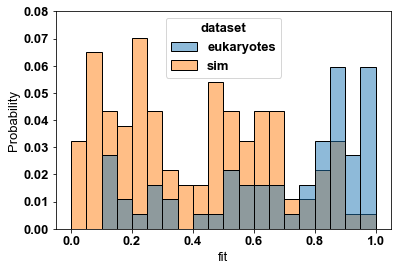

In [117]:
xs = bestModelsBySimDict["sim_m3_lim"]
xss = [['sim',y[3]] for y in xs if y[1]=='m3_lim']

dfSimM3Lim = pd.DataFrame(xss,columns = ['dataset','fit'])

thisdf = pd.concat([alldf[alldf['dataset']=='eukaryotes']
,dfSimM3Lim]).reset_index()


sns.histplot(data =thisdf,x = 'fit',hue = 'dataset',common_bins=False,stat="probability",bins=20,binrange=[0,1.0])
plt.ylim(0,0.08)
plt.show()

In [125]:
initTestDict = {x:0 for x in testModelNames}
#print(initTestDict)
confusionDict = { x:initTestDict.copy() for x in simModelNames}
confusionDict


maxPercentile = 1.1

for name in simModelNames:
    res = bestModelsBySimDict[name]
    failList = [model for idx,model,score,fit in res if fit > maxPercentile]
    successList = [model for idx,model,score,fit in res if fit <= maxPercentile]
    counts = Counter(successList)
    
    for m,c in list(zip( list(counts.keys()), list(counts.values()) )):
        confusionDict[name][m] = confusionDict[name][m]+int(c)
    
    confusionDict[name]["fail"] = len(failList)
                    


# confusionDict   

sim_m0


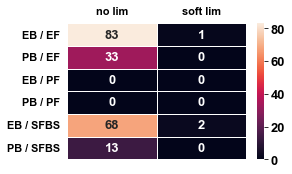

sim_m0_lim


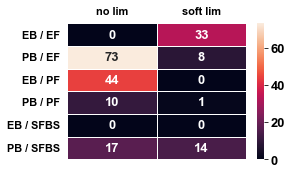

sim_m1


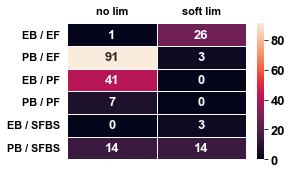

sim_m1_lim


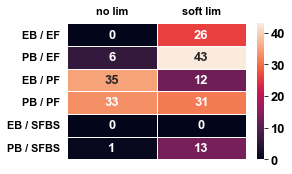

sim_m2


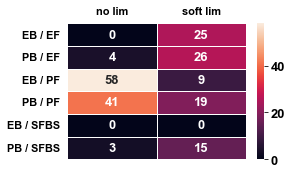

sim_m2_lim


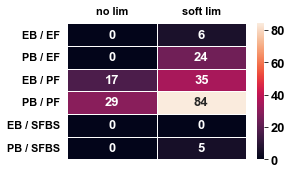

sim_m3


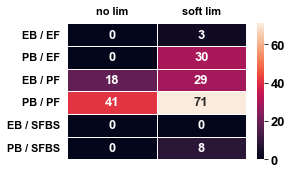

sim_m3_lim


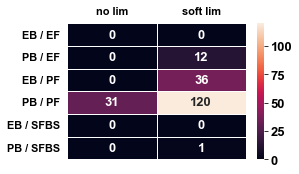

sim_m4


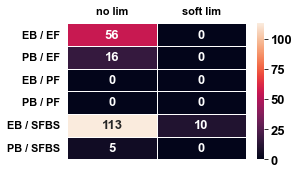

sim_m4_lim


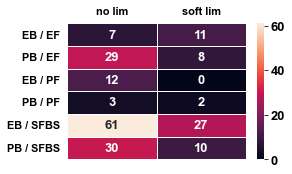

sim_m5


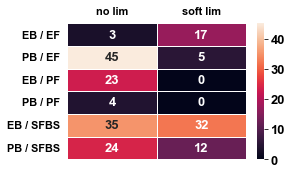

sim_m5_lim


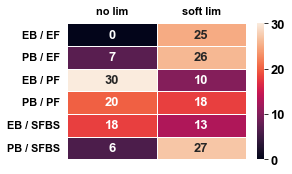

In [127]:
for simName in simModelNames:
    t = confusionDict[simName]
    print(simName)
    grid = [
        [t['m0'],t['m0_lim']],
        [t['m1'],t['m1_lim']],
        [t['m2'],t['m2_lim']],
        [t['m3'],t['m3_lim']],
        [t['m4'],t['m4_lim']],
        [t['m5'],t['m5_lim']],
    ]
    grid = pd.DataFrame(grid)
    mask = grid.isnull()
    ylabels = ['EB / EF','PB / EF','EB / PF','PB / PF','EB / SFBS','PB / SFBS']
    #ylabels = ['fail'," ",'m0','m1','m2','m3','m4','m5']
    xlabels = ['no lim', 'soft lim']
    plt.figure(figsize=(4,2.5))

    ax = sns.heatmap(grid,mask = mask,
                     annot=True,fmt = 'g',vmin=0,square=False,xticklabels=xlabels,yticklabels=ylabels,linewidths=1.0)
    plt.yticks(rotation=0)
    ax.tick_params(left=False,bottom=False,labelsize=11,labelbottom=False,labeltop=True)
    plt.show()

## confusion matrix -- restricting to non-lim models

In [356]:
localModelList = ["m0","m1","m2","m3","m4","m5"]

In [357]:
test1 = modelScoresDict["sim_m0"].copy()
test1 = test1[localModelList]
test1

,m0,m1,m2,m3,m4,m5
0,"[0.006413124142578675, 0.18768619662363456]","[0.04812949377968167, 0.9980119284294234]","[0.0743087084636471, 1.0]","[0.08818338415815424, 1.0]","[0.02714878786551695, 0.590818363273453]","[0.03242886147376152, 0.8551448551448552]"
1,"[0.012709023182099651, 0.3624627606752731]","[0.025246135156462176, 0.9840954274353877]","[0.04426659561850628, 1.0]","[0.05497854967400779, 1.0]","[0.042716158552577765, 0.7724550898203593]","[0.019961530055426478, 0.7422577422577422]"
2,"[0.017412214914117312, 0.48063555114200596]","[0.04375053821416604, 0.9980119284294234]","[0.06425734321450076, 1.0]","[0.0754934746033642, 1.0]","[0.04044647161019512, 0.7524950099800399]","[0.03150477627067972, 0.8541458541458542]"
3,"[0.006566887429273993, 0.1916583912611718]","[0.08192479696357316, 1.0]","[0.11330911715110945, 1.0]","[0.1293391932308683, 1.0]","[0.0052200176187484505, 0.16167664670658682]","[0.045982268685782354, 0.8851148851148851]"
4,"[0.02261530648430942, 0.5978152929493545]","[0.11596053162187232, 1.0]","[0.15069128542851312, 1.0]","[0.16810434344525105, 1.0]","[0.016308665013863542, 0.4281437125748503]","[0.07395999338370006, 0.9330669330669331]"
...,...,...,...,...,...,...
195,"[0.005902643763696498, 0.17378351539225423]","[0.0437150935445615, 0.9980119284294234]","[0.0688153091719029, 1.0]","[0.08221709644268636, 1.0]","[0.02721430409920994, 0.5948103792415169]","[0.029029120134308944, 0.8461538461538461]"
196,"[0.010296824213535925, 0.2869910625620655]","[0.04054910651894843, 0.9960238568588469]","[0.06452069510524555, 1.0]","[0.07747865893140662, 1.0]","[0.03355270208928209, 0.6706586826347305]","[0.028240269015891904, 0.8421578421578422]"
197,"[0.014886751795190072, 0.42502482621648463]","[0.013675679372799518, 0.9622266401590457]","[0.028797154384696533, 1.0]","[0.03784011096332337, 1.0]","[0.039360162304206955, 0.7425149700598802]","[0.006466999408040121, 0.2947052947052947]"
198,"[0.022889149883322003, 0.6037735849056604]","[0.005311703901426482, 0.794234592445328]","[0.015631487024149765, 0.996031746031746]","[0.022443632234423007, 1.0]","[0.05427792437484387, 0.8772455089820359]","[0.004843014903381376, 0.21978021978021978]"


In [358]:
bestModelsBySimDict = {}

for simName in simModelNames:
    
    bestModels = []

    test1 = modelScoresDict[simName].copy()
    test1 = test1[localModelList]

    for idx in range(numSamples):
        x_ = test1.loc[idx]
        x_ = list(x_)
        scores = [xs[0] for xs in x_]
        fits = [xs[1] for xs in x_]
        minScore = min(scores)
        idxMin = scores.index(minScore)

        bestModels.append([idx,localModelList[idxMin],scores[idxMin],fits[idxMin]])
    
    bestModelsBySimDict[simName] = bestModels




In [364]:
initTestDict = {x:0 for x in testModelNames}
#print(initTestDict)
confusionDict = { x:initTestDict.copy() for x in simModelNames}
confusionDict


maxPercentile = 0.99

for name in simModelNames:
    res = bestModelsBySimDict[name]
    failList = [model for idx,model,score,fit in res if fit >= maxPercentile]
    successList = [model for idx,model,score,fit in res if fit < maxPercentile]
    counts = Counter(successList)
    
    for m,c in list(zip( list(counts.keys()), list(counts.values()) )):
        confusionDict[name][m] = confusionDict[name][m]+int(c)
    
    confusionDict[name]["fail"] = len(failList)
                    


# confusionDict   

sim_m0


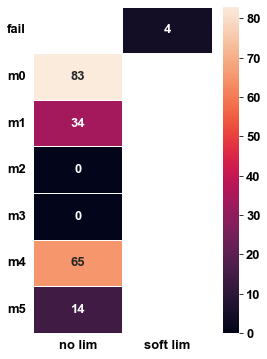

sim_m0_lim


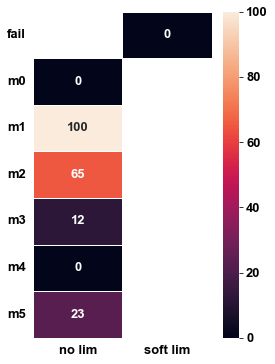

sim_m1


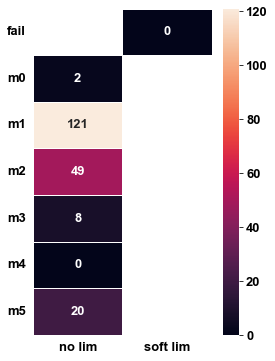

sim_m1_lim


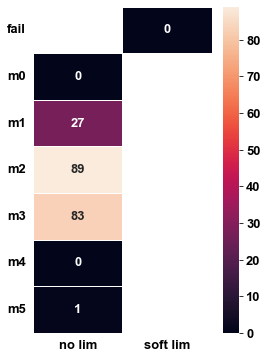

sim_m2


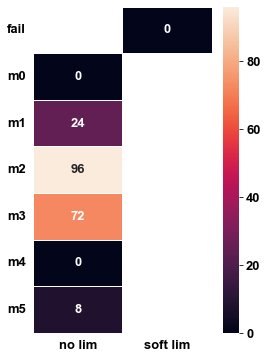

sim_m2_lim


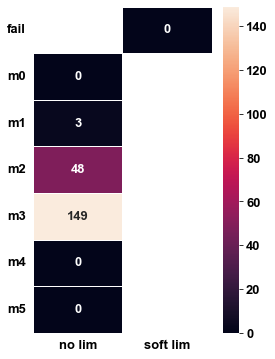

sim_m3


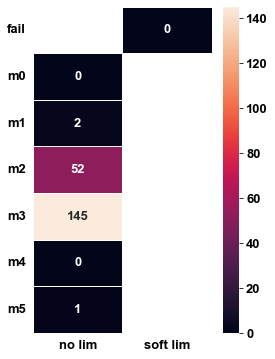

sim_m3_lim


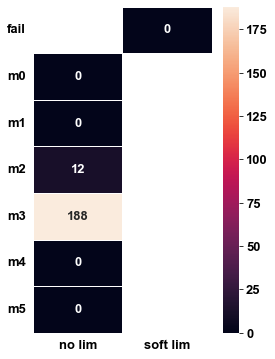

sim_m4


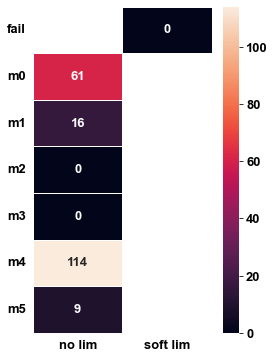

sim_m4_lim


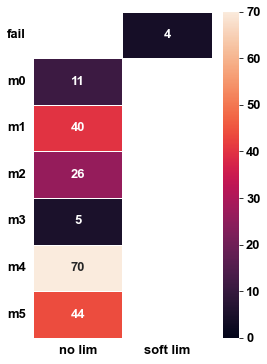

sim_m5


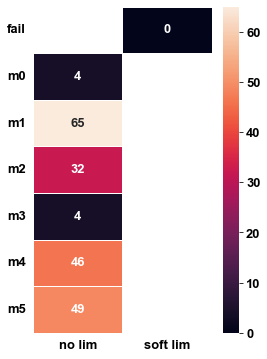

sim_m5_lim


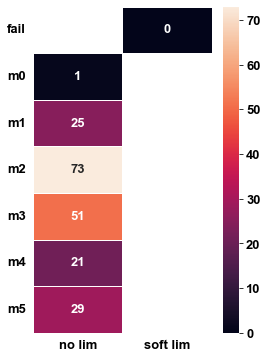

In [365]:
for simName in simModelNames:
    t = confusionDict[simName]
    print(simName)
    grid = [
        [None,t['fail']],
        [t['m0'],None],
        [t['m1'],None],
        [t['m2'],None],
        [t['m3'],None],
        [t['m4'],None],
        [t['m5'],None]
    ]
    grid = pd.DataFrame(grid)
    mask = grid.isnull()
    #ylabels = ['fail']+['EB / EF ','PB / EF','EB / PF','PB / PF','EB / SFBS','PB / SFBS']
    ylabels = ['fail','m0','m1','m2','m3','m4','m5']
    xlabels = ['no lim', 'soft lim']
    plt.figure(figsize=(4,6))

    ax = sns.heatmap(grid,mask = mask,
                     annot=True,fmt = 'g',vmin=0,square=False,xticklabels=xlabels,yticklabels=ylabels,linewidths=1.0)
    plt.yticks(rotation=0)
    ax.tick_params(left=False,bottom=False)
    plt.show()

## confusion matrix -- restricting to soft lim models

In [366]:
localModelList = ["m0_lim","m1_lim","m2_lim","m3_lim","m4_lim","m5_lim"]

In [367]:
test1 = modelScoresDict["sim_m0"].copy()
test1 = test1[localModelList]
test1

,m0_lim,m1_lim,m2_lim,m3_lim,m4_lim,m5_lim
0,"[0.05423436742899797, 1.0]","[0.0755215774005299, 1.0]","[0.08928661147059036, 1.0]","[0.09772430620039155, 1.0]","[0.029498382303815646, 0.6367265469061876]","[0.054014957882366245, 0.9023904382470119]"
1,"[0.02967446428046486, 0.9950445986124876]","[0.04520847815988284, 1.0]","[0.05592169095078371, 1.0]","[0.06262395700492279, 1.0]","[0.025298332318743785, 0.563872255489022]","[0.03254564199076195, 0.8814741035856574]"
2,"[0.048106798892567915, 1.0]","[0.06524076772274856, 1.0]","[0.07642603561276193, 1.0]","[0.08337446644783444, 1.0]","[0.031135616051645387, 0.6656686626746507]","[0.04701426238788169, 0.8934262948207171]"
3,"[0.08863387588927985, 1.0]","[0.11473331370698103, 1.0]","[0.1305584842858739, 1.0]","[0.1401245245543054, 1.0]","[0.028073631021051162, 0.6117764471057884]","[0.07738223728213865, 0.9282868525896414]"
4,"[0.12320722315546115, 1.0]","[0.152226271733798, 1.0]","[0.1693636474718204, 1.0]","[0.1796635665634552, 1.0]","[0.050728224949852276, 0.8562874251497006]","[0.10969894284904202, 0.9571713147410359]"
...,...,...,...,...,...,...
195,"[0.04953897607753052, 1.0]","[0.06998763799114888, 1.0]","[0.08328962401679474, 1.0]","[0.09147314277052374, 1.0]","[0.026941355628952803, 0.593812375249501]","[0.04941583603571544, 0.896414342629482]"
196,"[0.04627355684335115, 1.0]","[0.06565771132710924, 1.0]","[0.07853442548034857, 1.0]","[0.08648111204606702, 1.0]","[0.02842727097733665, 0.6197604790419161]","[0.04710005138834735, 0.8934262948207171]"
197,"[0.017103510402314885, 0.9781962338949455]","[0.029617637410982885, 1.0]","[0.038690742839227306, 1.0]","[0.04447190216959408, 1.0]","[0.011941606528342301, 0.3283433133732535]","[0.016325752928304633, 0.8416334661354582]"
198,"[0.007390954094809284, 0.9038652130822596]","[0.016230492764534303, 0.9970119521912351]","[0.02310331616672706, 1.0]","[0.027627064292617198, 1.0]","[0.0151458370791172, 0.38323353293413176]","[0.008463813683685144, 0.5876494023904383]"


In [368]:
bestModelsBySimDict = {}

for simName in simModelNames:
    
    bestModels = []

    test1 = modelScoresDict[simName].copy()
    test1 = test1[localModelList]

    for idx in range(numSamples):
        x_ = test1.loc[idx]
        x_ = list(x_)
        scores = [xs[0] for xs in x_]
        fits = [xs[1] for xs in x_]
        minScore = min(scores)
        idxMin = scores.index(minScore)

        bestModels.append([idx,localModelList[idxMin],scores[idxMin],fits[idxMin]])
    
    bestModelsBySimDict[simName] = bestModels




In [376]:
initTestDict = {x:0 for x in testModelNames}
#print(initTestDict)
confusionDict = { x:initTestDict.copy() for x in simModelNames}
confusionDict


maxPercentile = 0.95

for name in simModelNames:
    res = bestModelsBySimDict[name]
    failList = [model for idx,model,score,fit in res if fit >= maxPercentile]
    successList = [model for idx,model,score,fit in res if fit < maxPercentile]
    counts = Counter(successList)
    
    for m,c in list(zip( list(counts.keys()), list(counts.values()) )):
        confusionDict[name][m] = confusionDict[name][m]+int(c)
    
    confusionDict[name]["fail"] = len(failList)
                    


# confusionDict   

sim_m0


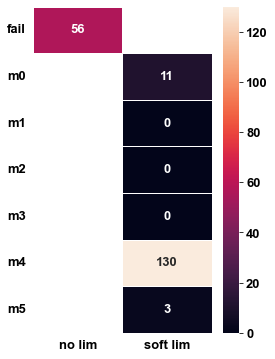

sim_m0_lim


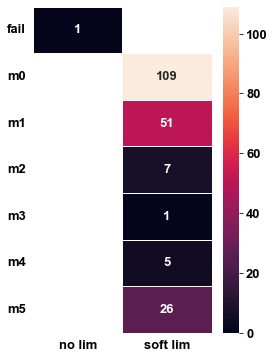

sim_m1


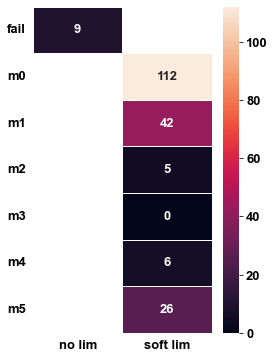

sim_m1_lim


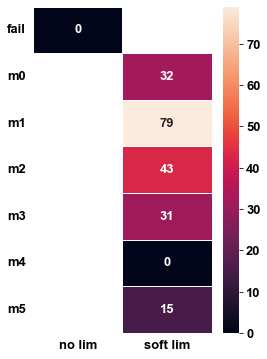

sim_m2


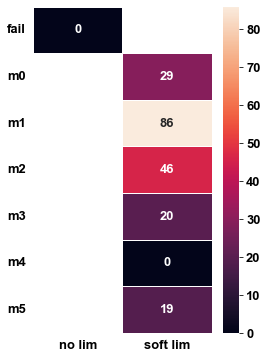

sim_m2_lim


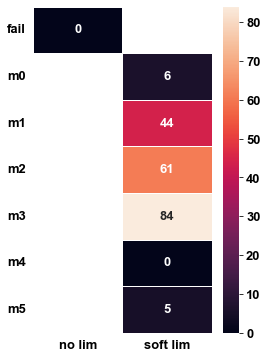

sim_m3


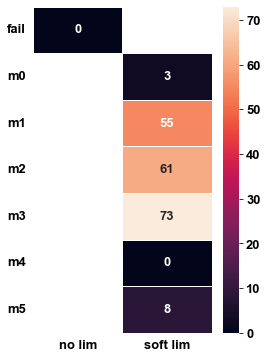

sim_m3_lim


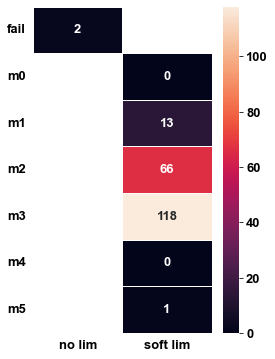

sim_m4


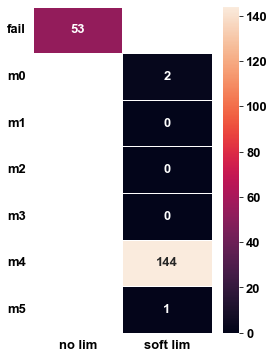

sim_m4_lim


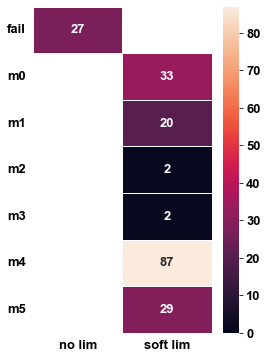

sim_m5


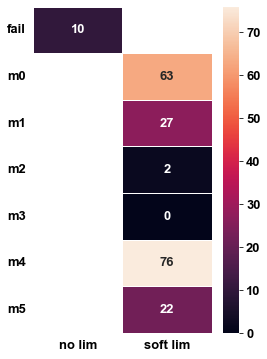

sim_m5_lim


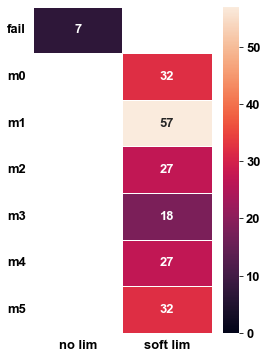

In [377]:
for simName in simModelNames:
    t = confusionDict[simName]
    print(simName)
    grid = [
        [t['fail'],None],
        [None,t['m0_lim']],
        [None,t['m1_lim']],
        [None,t['m2_lim']],
        [None,t['m3_lim']],
        [None,t['m4_lim']],
        [None,t['m5_lim']]
    ]
    grid = pd.DataFrame(grid)
    mask = grid.isnull()
    #ylabels = ['fail']+['EB / EF ','PB / EF','EB / PF','PB / PF','EB / SFBS','PB / SFBS']
    ylabels = ['fail','m0','m1','m2','m3','m4','m5']
    xlabels = ['no lim', 'soft lim']
    plt.figure(figsize=(4,6))

    ax = sns.heatmap(grid,mask = mask,
                     annot=True,fmt = 'g',vmin=0,square=False,xticklabels=xlabels,yticklabels=ylabels,linewidths=1.0)
    plt.yticks(rotation=0)
    ax.tick_params(left=False,bottom=False)
    plt.show()